# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

callsog = {}
pairsog = {}
livesog = {}

globalt0 = dt.datetime.now()

In [2]:
%time callsog['mit'] = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
%time pairsog['mit'] = pc.pairs(callsog['mit'])
%time livesog['mit'] = pc.lives_dictionary(callsog['mit'])
callsog['mit'].head()

CPU times: user 413 ms, sys: 43.5 ms, total: 456 ms
Wall time: 487 ms
CPU times: user 32.3 ms, sys: 0 ns, total: 32.3 ms
Wall time: 33.9 ms
CPU times: user 156 ms, sys: 1.36 ms, total: 157 ms
Wall time: 159 ms


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,307,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,450,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,328,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,454,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,400,0


Now UK. I'll be very careful, since I need to import all data, then create two cohorts and in the paper I'll probably end  up using only one: UK2

In [3]:
uk = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=1)
uk.head()

,ego,alter,time,uclock,aclock
0,C07814508939,C0020165636994,2008-02-07 16:18:00,339,0
1,C07814508939,C0020165636994,2008-02-07 17:11:00,339,0
2,C07814508939,C0020165636994,2008-02-20 15:39:00,352,13
3,C07792658311,C0021213487966,2008-02-27 17:01:00,359,0
4,C07792658311,C0021213487966,2008-02-27 17:55:00,359,0


In [4]:
# Temporary data, since I will create two cohorts out of these
tmp2 = pc.pairs(uk)
tmp3 = pc.lives_dictionary(uk)

rmalter = {}
for ego in tmp3.keys():
    rmalter[ego] = []
    for alter in tmp3[ego].keys():
        if tmp3[ego][alter]['t0'] < 180:
            rmalter[ego].append(alter)
            
for i in uk.index:
    ego = uk.at[i, 'ego']
    alter = uk.at[i, 'alter']
    if alter in rmalter[ego]:
        uk.at[i, 'rm'] = 1
    else:
        uk.at[i, 'rm'] = 0

callsog['uk1'] = uk.loc[uk['rm'] == 1]
callsog['uk1'].drop(columns=['rm'], inplace=True)
callsog['uk1'].reset_index(drop=True, inplace=True)

new = uk.loc[uk['rm'] == 0]
new = new.loc[new['uclock'] >= 180]
new['uclock'] -= 180
new.to_csv("tmp2.csv")
callsog['uk2'] = pc.allcalls("tmp2.csv", (), 'ego', 'alter', ['time'], '%Y-%m-%d %H:%M:%S')
callsog['uk2'].reset_index(drop=True, inplace=True)
os.system("rm tmp2.csv")

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0

## Limit data

In order to make all pairs of ego-alters (in all three cohorts comparable, I will limit the amount of phone calls to be analized, using the following criteria:

1. Only consider phone calls made by egos 30 days or later than their first appeareance.
2. For each alter, its maximum value of $a$ will be 200 days. This makes $\max_{\ell} = 200$.
3. Remove all alters whose first appeareance was **after** $T - \max{a}$. This is to guarantee that every alter could potentially reach $\max{a}$.

### Remove first 30 days of activity for each ego

In [93]:
calls = {}
for c in callsog.keys():
    uno = callsog[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in callsog[c]['ego'].unique():
        df = callsog[c].loc[callsog[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(callsog[c])
    calls[c] = dos
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 19098 calls
uk1 lost 5733 calls
uk2 lost 1684 calls
uk lost 5733 calls
all lost 24831 calls


### Make $a_{\max} = 200$

In [94]:
for c in calls.keys():
    old = len(calls[c])
    calls[c] = calls[c].loc[calls[c]['aclock'] <= 200]
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 24426 calls
uk1 lost 37748 calls
uk2 lost 3229 calls
uk lost 40976 calls
all lost 65402 calls


### Remove all alters with $t(0) > T - a_{\max}$

In [95]:
for c in calls.keys():
    uno = pd.DataFrame()
    T = max(calls[c]['uclock'])
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df2.loc[:, 'aclock'] = df2['uclock'] - mint
                uno = uno.append(df2).reset_index(drop=True)
    old = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    calls[c] = uno
    new = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    print(f'{c} lost {old - new} pairs of ego-alter')

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


mit lost 7649 pairs of ego-alter
uk1 lost 38 pairs of ego-alter
uk2 lost 1905 pairs of ego-alter
uk lost 1894 pairs of ego-alter
all lost 7281 pairs of ego-alter


In [8]:
calls['uk'] = uk
calls['all'] = pd.DataFrame()
for c in ['mit', 'uk2']:
    calls['all'] = calls['all'].append(calls[c]).reset_index(drop=True)

Now Italy data, considering I don't have phone call data, but aggregated by lifetime and age

In [9]:
import pickle

t0 = dt.datetime.now()

#with open('../itdata/mtl1_lambda_alpha_fig1.pickle', 'rb') as handle:
#    it1 = pickle.load(handle)
#    handle.close()
    
with open('../itdata/mtl2_lambda_alpha_fig1.pickle', 'rb') as handle:
    it2 = pickle.load(handle)
    handle.close()
    

# dffit2 = {}
# dffit2['all'] = {}
# data = [it1, it2]
# dname = ['it1', 'it2']
# for c in range(2):
#     dffit2[dname[c]] = {}
#     for ego in data[c].keys():
#         key = f'{dname[c]}{ego}'
#         dffit2[f'{dname[c]}'][key] = data[c][ego]
#         dffit2['all'][key] = data[c][ego]
# print(f'Took {dt.datetime.now() - t0}')

# Fig 2: stable number of phone calls $b$
Using only MIT, UK2, and Italy2

In [10]:
dff = pc.get_f(calls['all'], 'all', 10, 70)
print(len(dff.keys()))
for ego in it2.keys():
    dff[ego] = it2[ego]
print(len(dff.keys()))

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


155
291


In [11]:
b = pc.get_b(dff, 'alpha')
updatefig1b = pc.plot_g(b, 'alpha')

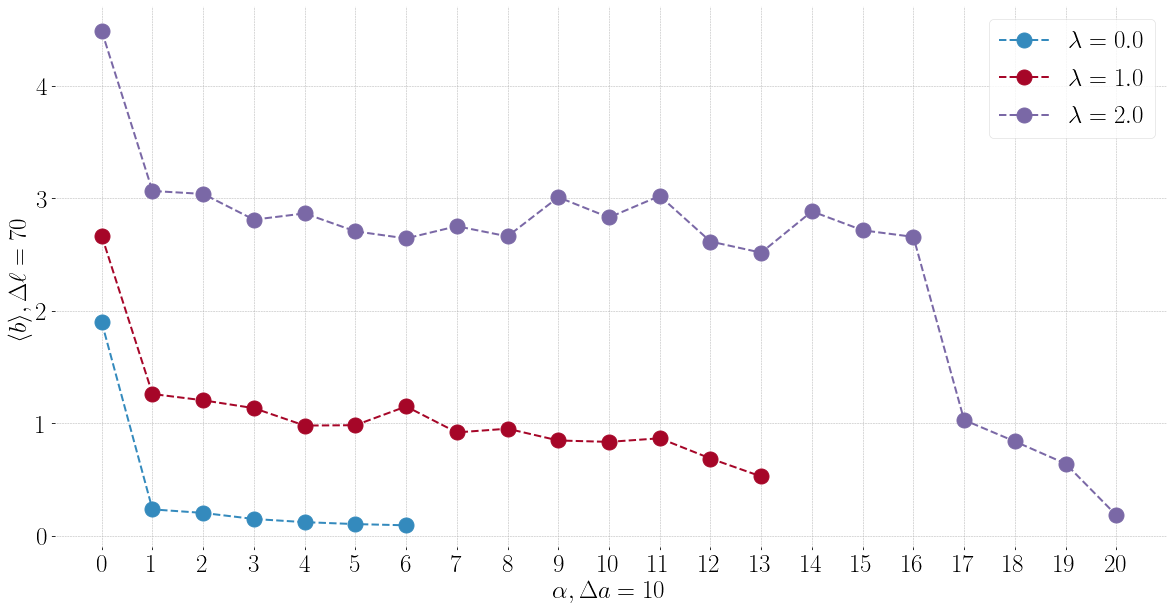

In [12]:
plt.ylabel(fr"$\langle b \rangle, \Delta \ell = 70$")
plt.xlabel(r"$\alpha, \Delta a = 10$")
plt.xticks(range(21))
for lamb in updatefig1b.keys():
    plt.plot(updatefig1b[int(lamb)].index, updatefig1b[int(lamb)]['alpha'], marker="o", markersize=15, ls="--", c=colors[int(lamb)], label=fr'$\lambda = {lamb}$')
plt.legend()

In [13]:
plateaus = {}
for s in updatefig1b.keys():
    plateaus[s] = pc.get_plateau(updatefig1b[s], allowed=1)
plateaus

{0.0: (1.0, 5.0, 0.1605331456742336),
 1.0: (1.0, 13.0, 0.9483419222265262),
 2.0: (4.0, 16.0, 2.760052037067329)}

In [14]:
# tmp = pd.DataFrame()
# for s in updatefig1b.keys():
#     df = updatefig1b[s]
#     df.columns = [f'l{int(s)}']
#     if len(tmp) == 0:
#         tmp = tmp.append(df)
#     else:
#         tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
# tmp.index.rename('alpha', inplace=True)
# tmp.fillna('nan', inplace=True)
# tmp.to_csv(f"../commpatterns/data/blamballb.dat", header=True, sep="\t")

## Inset updated by excluding UK1 and Italy1

In [15]:
with open('../itdata/fig1_F.pickle', 'rb') as handle:
    itinset = pickle.load(handle)
    handle.close()

In [16]:
ex = 'it137'
ex[3:]

'37'

In [17]:
t0 = dt.datetime.now()
itinsetb = {}
for Dl in itinset.keys():
    itinsetb[Dl] = {}
    for ego in itinset[Dl].keys():
        if ego[2] == '2':
            newkey = np.int64(ego[3:])
            itinsetb[Dl][newkey] = itinset[Dl][ego]
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.000668


In [18]:
itinsetb[40].keys()

dict_keys([233, 37, 79, 240, 272, 66, 24, 38, 63, 69, 89, 34, 90, 258, 201, 275, 202, 221, 223, 228, 113, 255, 268, 207, 253, 93, 249, 219, 83, 92, 194, 251, 247, 265, 254, 80, 205, 238, 212, 242, 86, 41, 232, 53, 230, 239, 32, 246, 27, 65, 75, 31, 203, 43, 224, 76, 199, 273, 47, 68, 112, 42, 26, 259, 77, 227, 277, 237, 36, 71, 211, 252, 84, 57, 60, 58, 231, 241, 59, 97, 274, 62, 30, 28, 96, 67, 213, 250, 45, 56, 266, 70, 50, 260, 270, 78, 225, 88, 264, 235, 73, 39, 195, 81, 222, 243, 29, 206, 229, 94, 35, 257, 196, 44, 95, 198, 91, 210, 248, 209, 262, 48, 261, 263, 49, 236, 256, 245, 269, 74, 220, 33, 64, 87, 267, 98])

In [19]:
t0 = dt.datetime.now()
bplots = {}
for Dl in range(40, 71, 5):
    dff = pc.get_f(calls['all'], 'all', 10, Dl)
    dff.update(itinsetb[Dl])
    b = pc.get_b(dff, 'alpha')
    bplots[Dl] = pc.plot_g(b, 'alpha')
print(f'This block took {dt.datetime.now() - t0}')

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


This block took 0:02:29.274140


In [20]:
plateaus = {}
for Dl in [50, 55, 60, 65, 70]:
    for lamb in bplots[Dl].keys():
        ell = int((lamb + 0.5) * Dl)
        if ell not in plateaus.keys():
            xmin, xmax, height = pc.get_plateau(bplots[Dl][lamb])
            plateaus[ell] = height
platplot = pd.DataFrame.from_dict(plateaus, orient='index').sort_index()

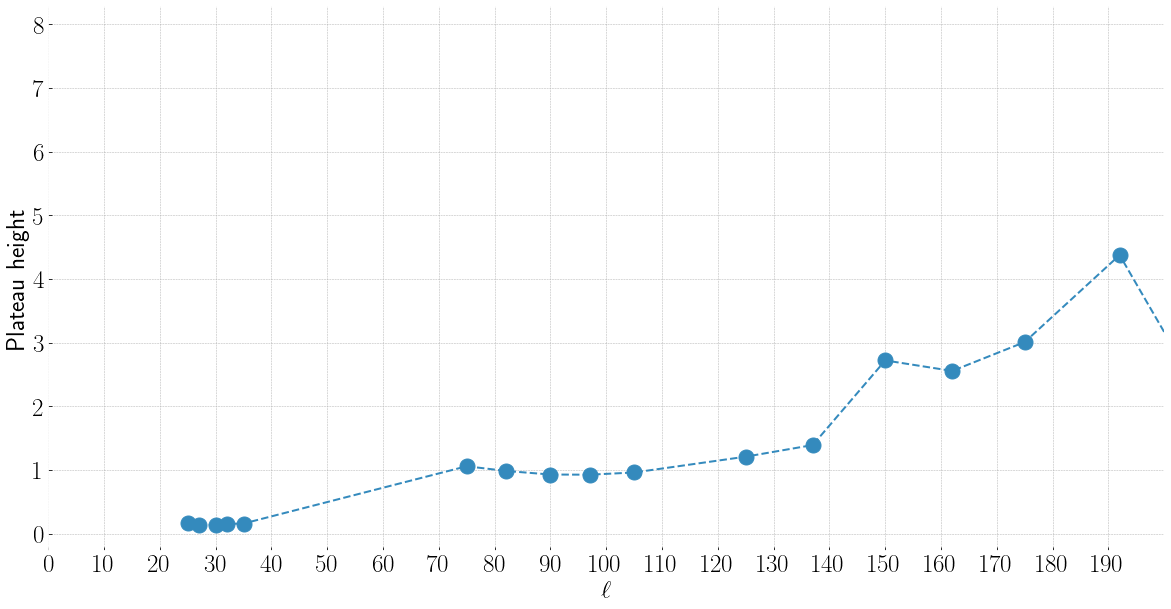

In [21]:
plt.xlabel(r"$\ell$")
plt.ylabel("Plateau height")
plt.xlim(0, 200)
plt.xticks(range(0, 200, 10))
plt.plot(platplot.index, platplot[0], marker="o", markersize=15, ls="--")

In [22]:
# tmp = platplot.loc[platplot.index < 200]
# tmp.columns = ['y']
# tmp.index.rename('x', inplace=True)
# tmp.fillna('nan', inplace=True)
# tmp.to_csv("../commpatterns/data/plateaub.dat", header=True, sep="\t")

# Fig 3: Survival probabilities
Using only MIT, UK2, and Italy2

In [23]:
with open('../itdata/mtl2_lambda_alpha_fig2.pickle', 'rb') as handle:
    it2b = pickle.load(handle)
    handle.close()

In [24]:
dff2 = pc.get_f(calls['all'], 'all', 30, 10)
print(len(dff2.keys()))
for ego in it2b.keys():
    dff2[ego] = it2b[ego]
print(len(dff2.keys()))

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


155
291


In [25]:
allsurvival = pc.get_survival(dff2)

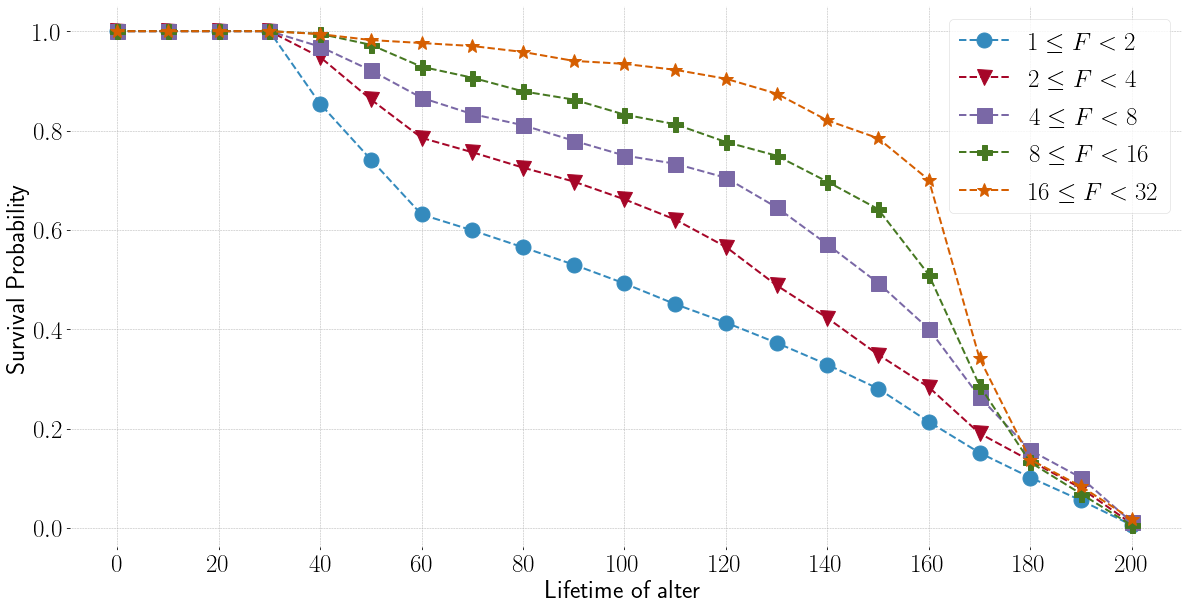

In [26]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(5)]
plt.xlabel("Lifetime of alter")
plt.xticks(range(0, 201, 20))
plt.ylabel("Survival Probability")
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(5)]
for F in range(5):
    plt.plot(allsurvival[F].index * 10, allsurvival[F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.legend()

In [27]:
# tmp = pd.DataFrame({'lc': list(allsurvival[0].index)})
# for F in range(5):
#     df = allsurvival[F]
#     tmp[f'p{F}'] = df[0]
# tmp.to_csv(f'../commpatterns/data/allsurvivalb.dat', header=False, index=False, sep="\t")

# Contour plots and italian dots on top 
Starting with UK1 and USA

In [28]:
dff3a = pc.get_f(calls['all'], 'all', 30, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [29]:
surv_contour = pc.get_survival(dff3a)

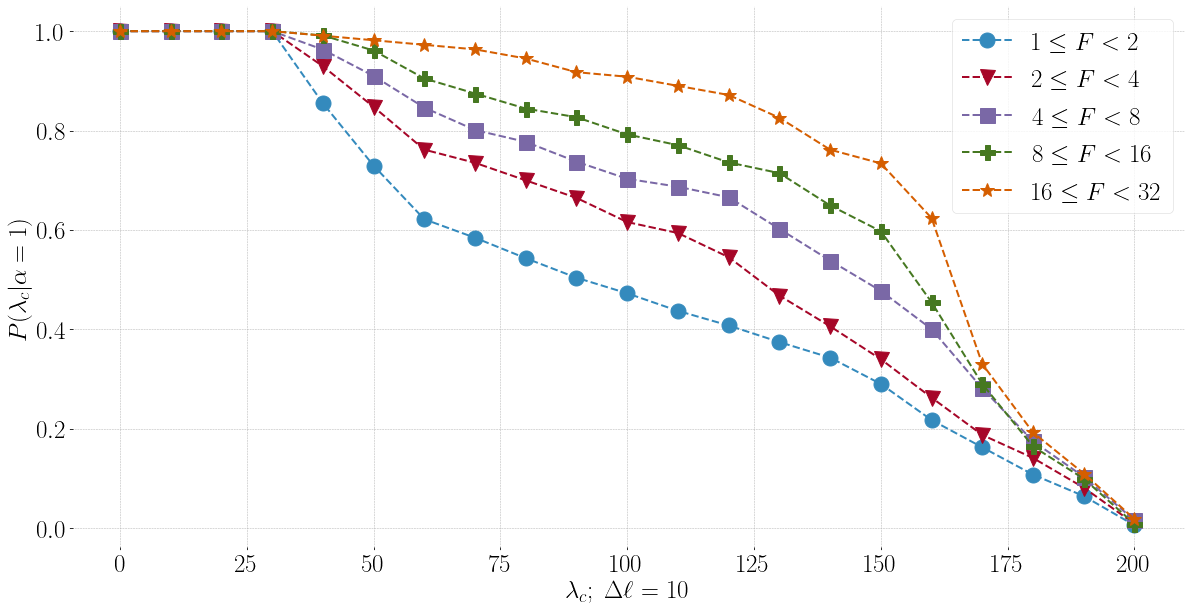

In [30]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(7)]

plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
m = 0
for f in range(5):
    plt.plot(surv_contour[f].index * 10, surv_contour[f][0], marker=markers[m], markersize=15, ls="--", label=fr'{series2[f]}')
    m += 1
plt.legend()

In [31]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_contour[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/data/contour2.dat", header=False, index=False, sep="\t")

And now the italian points

In [32]:
surv_points = pc.get_survival(it2b)

In [33]:
surv_points.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [34]:
# tmp = pd.DataFrame()
# for s in range(5):
#     df = surv_points[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df.drop(columns='z', inplace=True)
#     df.to_csv(f'../commpatterns/data/points{p}b.dat', header=False, index=False, sep="\t")
#     p += 1

# Attempt to classify older alters by their activity

The reasoning behind is the following: an older alter (likely in the core); will have a *normal* activity in the first month, since it is not really its first month in ego's network. We contrast this to a new alter, which will most likely have a higher activity at the beginning of the relationship

In [35]:
dff_uk1 = pc.get_f(callsog['uk1'], 'all', 30, 500)
dff_uk2 = pc.get_f(callsog['uk2'], 'all', 30, 500)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


To identify an *old* alter, I'll get length of the relationships (without the limitation of $\ell \leq 200$)

In [36]:
livesog = {}
for c in ['uk1', 'uk2']:
    livesog[c] = pc.lives_dictionary(callsog[c])

In [37]:
maxell = 0
uk1_ea = None
for ego in livesog['uk1'].keys():
    for alter in livesog['uk1'][ego].keys():
        if livesog['uk1'][ego][alter]['ell'] > maxell:
            maxell = livesog['uk1'][ego][alter]['ell']
            uk1_ea = (ego, alter)

In [38]:
livesog['uk1'][uk1_ea[0]][uk1_ea[1]]

{'t0': 0, 'tf': 534, 'nij': 656, 'ell': 534}

In [39]:
maxell = 0
uk2_ea = None
for ego in livesog['uk2'].keys():
    for alter in livesog['uk2'][ego].keys():
        if livesog['uk2'][ego][alter]['ell'] > maxell:
            maxell = livesog['uk2'][ego][alter]['ell']
            uk2_ea = (ego, alter)

In [40]:
livesog['uk2'][uk2_ea[0]][uk2_ea[1]]

{'t0': 2, 'tf': 349, 'nij': 581, 'ell': 347}

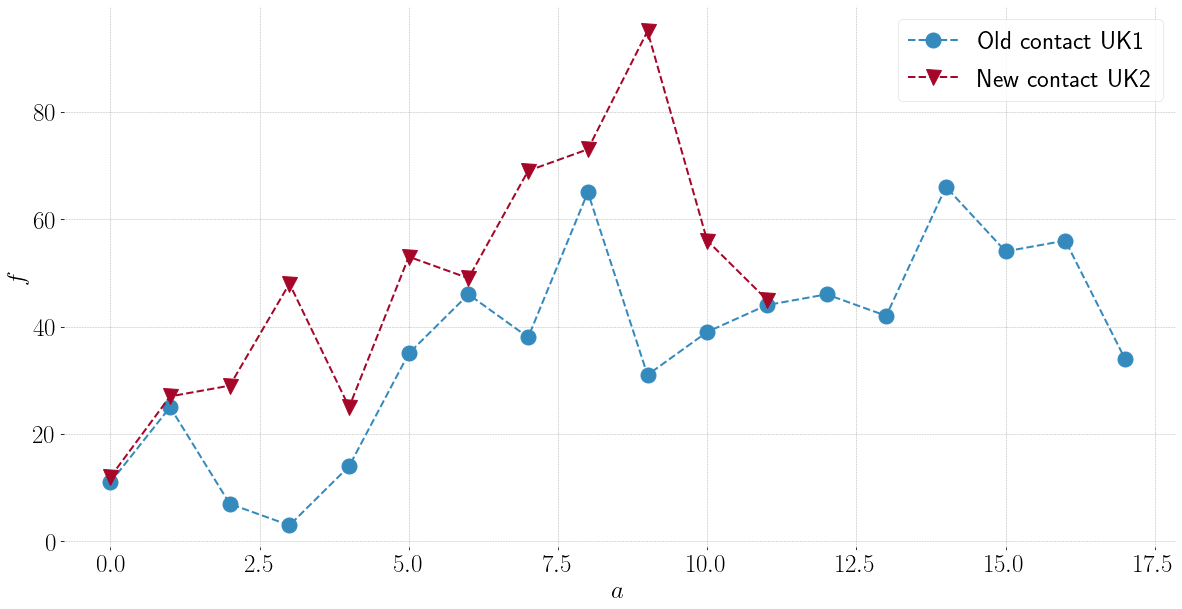

In [41]:
plt.xlabel(r"$a$")
plt.ylabel(r"$f$")
plt.plot(dff_uk1[uk1_ea[0]][uk1_ea[1]]['alpha'], dff_uk1[uk1_ea[0]][uk1_ea[1]]['f'], marker=markers[0], markersize=15, ls="--", label="Old contact UK1")
plt.plot(dff_uk2[uk2_ea[0]][uk2_ea[1]]['alpha'], dff_uk2[uk2_ea[0]][uk2_ea[1]]['f'], marker=markers[1], markersize=15, ls="--", label="New contact UK2")
plt.legend()

In [42]:
uk1_ea

('C07800643415', 'C07877438945')

In [43]:
uk2_ea

('C07896556837', 'C07814891967')

Now, I can look for the coefficients of variation for the interveent times between phonecalls

In [44]:
egos_uk1 = callsog['uk1'].loc[callsog['uk1']['ego'] == uk1_ea[0]]['ego'].unique()

In [45]:
egos_uk2 = callsog['uk2'].loc[callsog['uk2']['ego'] == uk2_ea[0]]['ego'].unique()

In [46]:
uk1_allpairs = {}
for ego in egos_uk1:
    uk1_allpairs[ego] = []
    df = callsog['uk1'].loc[callsog['uk1']['ego'] == ego]
    for alter in df['alter'].unique():
        uk1_allpairs[ego].append(alter)

In [47]:
uk2_allpairs = {}
for ego in egos_uk2:
    uk2_allpairs[ego] = []
    df = callsog['uk2'].loc[callsog['uk2']['ego'] == ego]
    for alter in df['alter'].unique():
        uk2_allpairs[ego].append(alter)

In [48]:
for ego in uk1_allpairs.keys():
    if ego not in uk2_allpairs.keys():
        print(ego)

C07800643415


# Explore parameters

In this section I will explore different parameters, filters, or values; always looking at the relationship between $g(a_o, a_f)$ and $\ell$. The first result considers UK and USA, no filters in the data

In [49]:
callsog['uk'] = uk

In [50]:
callsog['all'] = callsog['mit'].append(callsog['uk'])

In [51]:
livesog['all'] = pc.lives_dictionary(callsog['all'])

In [52]:
gl = []
gl.append(list())

In [53]:
t0 = dt.datetime.now()
for ego in callsog['all']['ego'].unique():
    df = callsog['all'].loc[callsog['all']['ego'] == ego]
    for alter in df['alter'].unique():
        df2 = df.loc[df['alter'] == alter]
        df3 = df2.loc[(df2['aclock'] >= 30) & (df2['aclock'] <= 60)]
        if len(df3) > 0:
            gl[0].append((len(df3), livesog['all'][ego][alter]['ell']))
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:20.994628


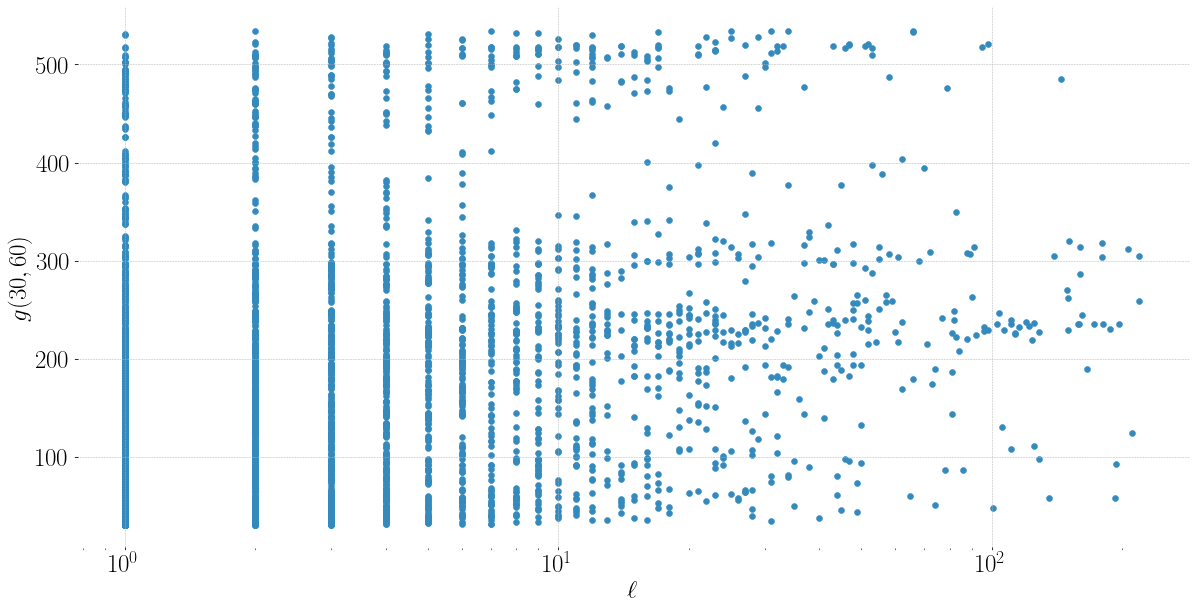

In [54]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$g(30, 60)$")
plt.xscale("log")
plt.scatter([i[0] for i in gl[0]], [i[1] for i in gl[0]])

## Remove some days at the beginning

Controlling for ego's new free phone calls, we'll take some days at the beginning of **ego**

In [55]:
tmp = {}
uno = callsog['all'].groupby('ego')[['uclock']].min()
for d in [15, 30, 60]:
    dos = pd.DataFrame()
    for ego in callsog['all']['ego'].unique():
        df = callsog['all'].loc[callsog['all']['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + d
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(callsog['all'])
    tmp[d] = dos
    print(f'{d} days lost {old - len(tmp[d])} calls')

15 days lost 12901 calls
30 days lost 24831 calls
60 days lost 49860 calls


In [56]:
t0 = dt.datetime.now()
for d in tmp.keys():
    gl.append(list())
    for ego in tmp[d]['ego'].unique():
        df = tmp[d].loc[tmp[d]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            df3 = df2.loc[(df2['aclock'] >= 30) & (df2['aclock'] <= 60)]
            if len(df3) > 0:
                gl[-1].append((len(df3), livesog['all'][ego][alter]['ell']))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:56.671394


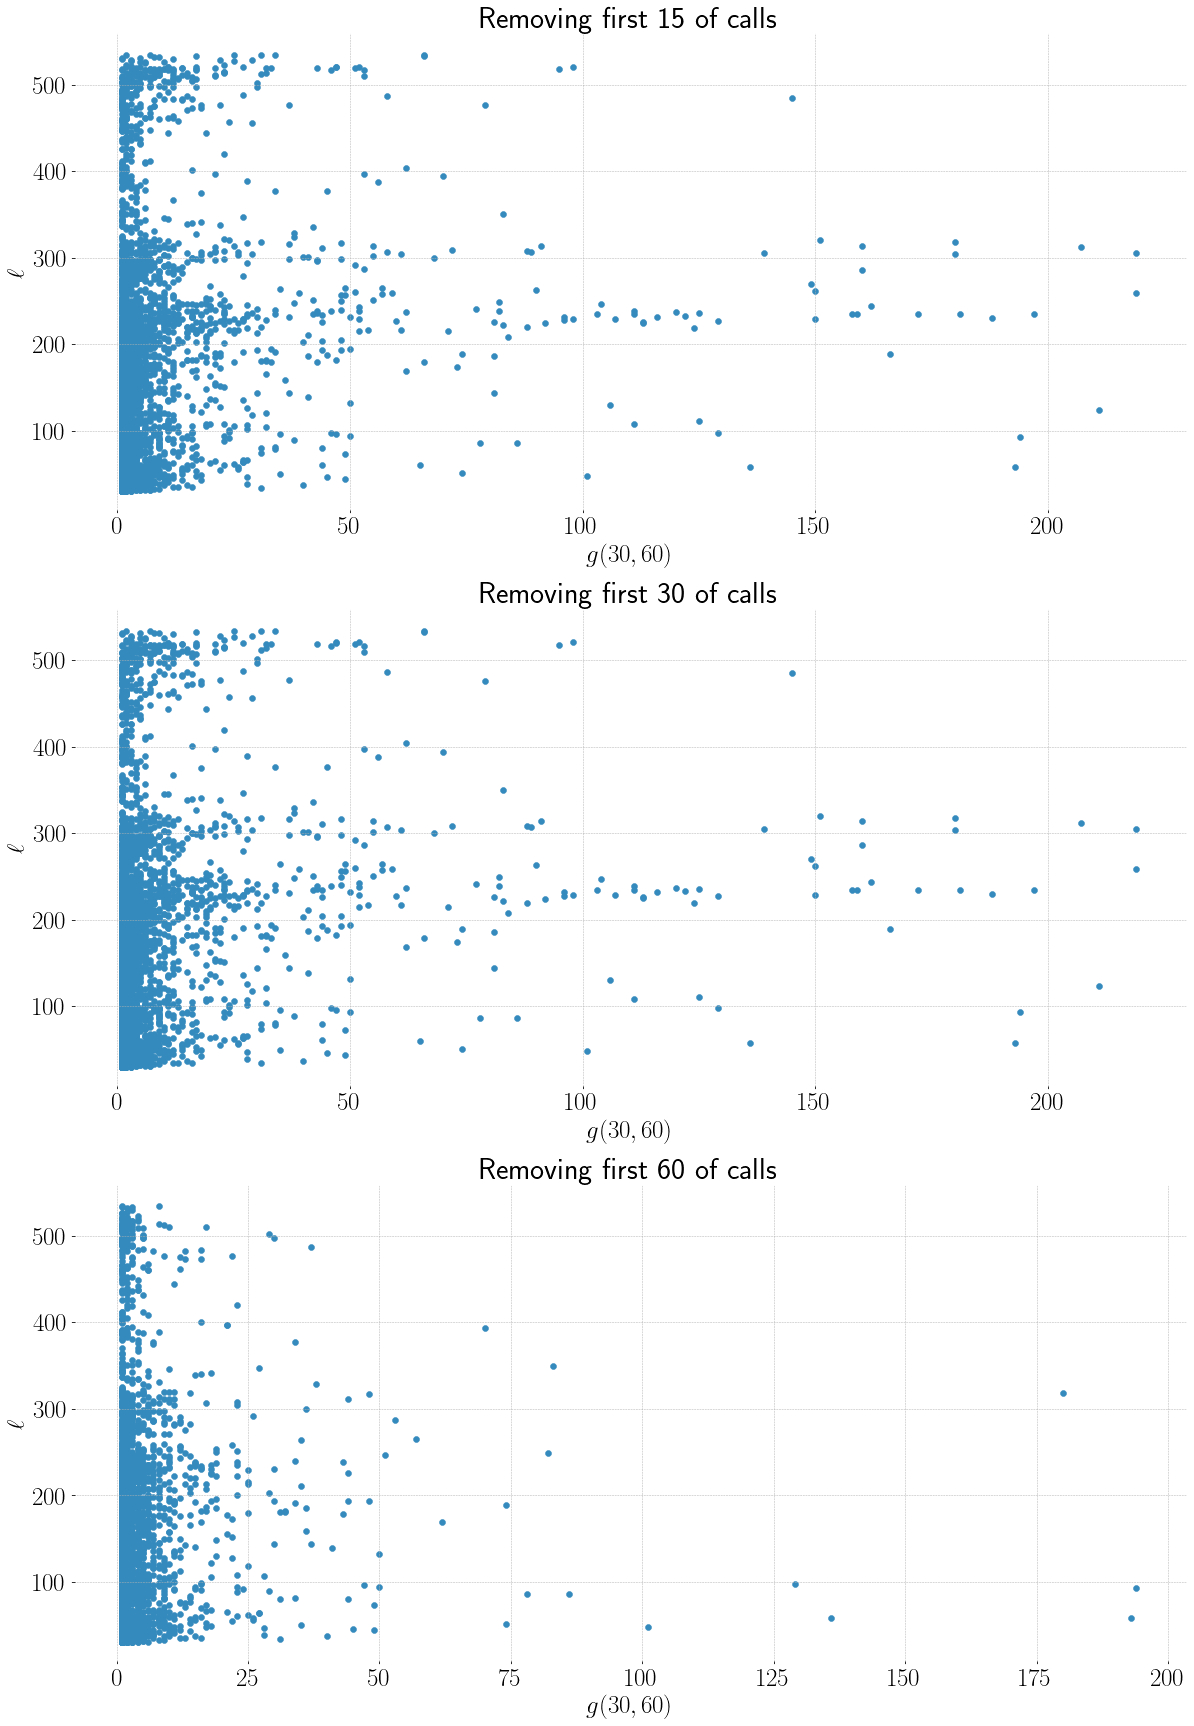

In [57]:
plt.figure(figsize=(20, 30))
days = [15, 30, 60]
for p in range(3):
    plt.subplot(3,1,p + 1)
    plt.title(f"Removing first {days[p]} of calls")
    plt.ylabel(r"$\ell$")
    plt.xlabel(r"$g(30, 60)$")
    #plt.yscale("logit")
    plt.scatter([i[0] for i in gl[p + 1]], [i[1] for i in gl[p + 1]])

## Limit $\ell$
Again, we can use different values. We'll limit $\ell$ to 200, 300, and 400

In [58]:
tmp = []
livesalt = {}
for maxell in [200, 300, 400]:
    old = len(callsog['all'])
    df = callsog['all'].loc[callsog['all']['aclock'] <= maxell]
    livesalt[maxell] = pc.lives_dictionary(df)
    print(f'Limit of {maxell} days lost {old - len(df)} calls')
    tmp.append(df)

Limit of 200 days lost 65402 calls
Limit of 300 days lost 25940 calls
Limit of 400 days lost 12978 calls


In [59]:
t0 = dt.datetime.now()
maxell = [200, 300, 400]
for i in range(3):
    gl.append(list())
    for ego in tmp[i]['ego'].unique():
        df = tmp[i].loc[tmp[i]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            df3 = df2.loc[(df2['aclock'] >= 30) & (df2['aclock'] <= 60)]
            if len(df3) > 0:
                gl[-1].append((len(df3), livesalt[maxell[i]][ego][alter]['ell']))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:59.885393


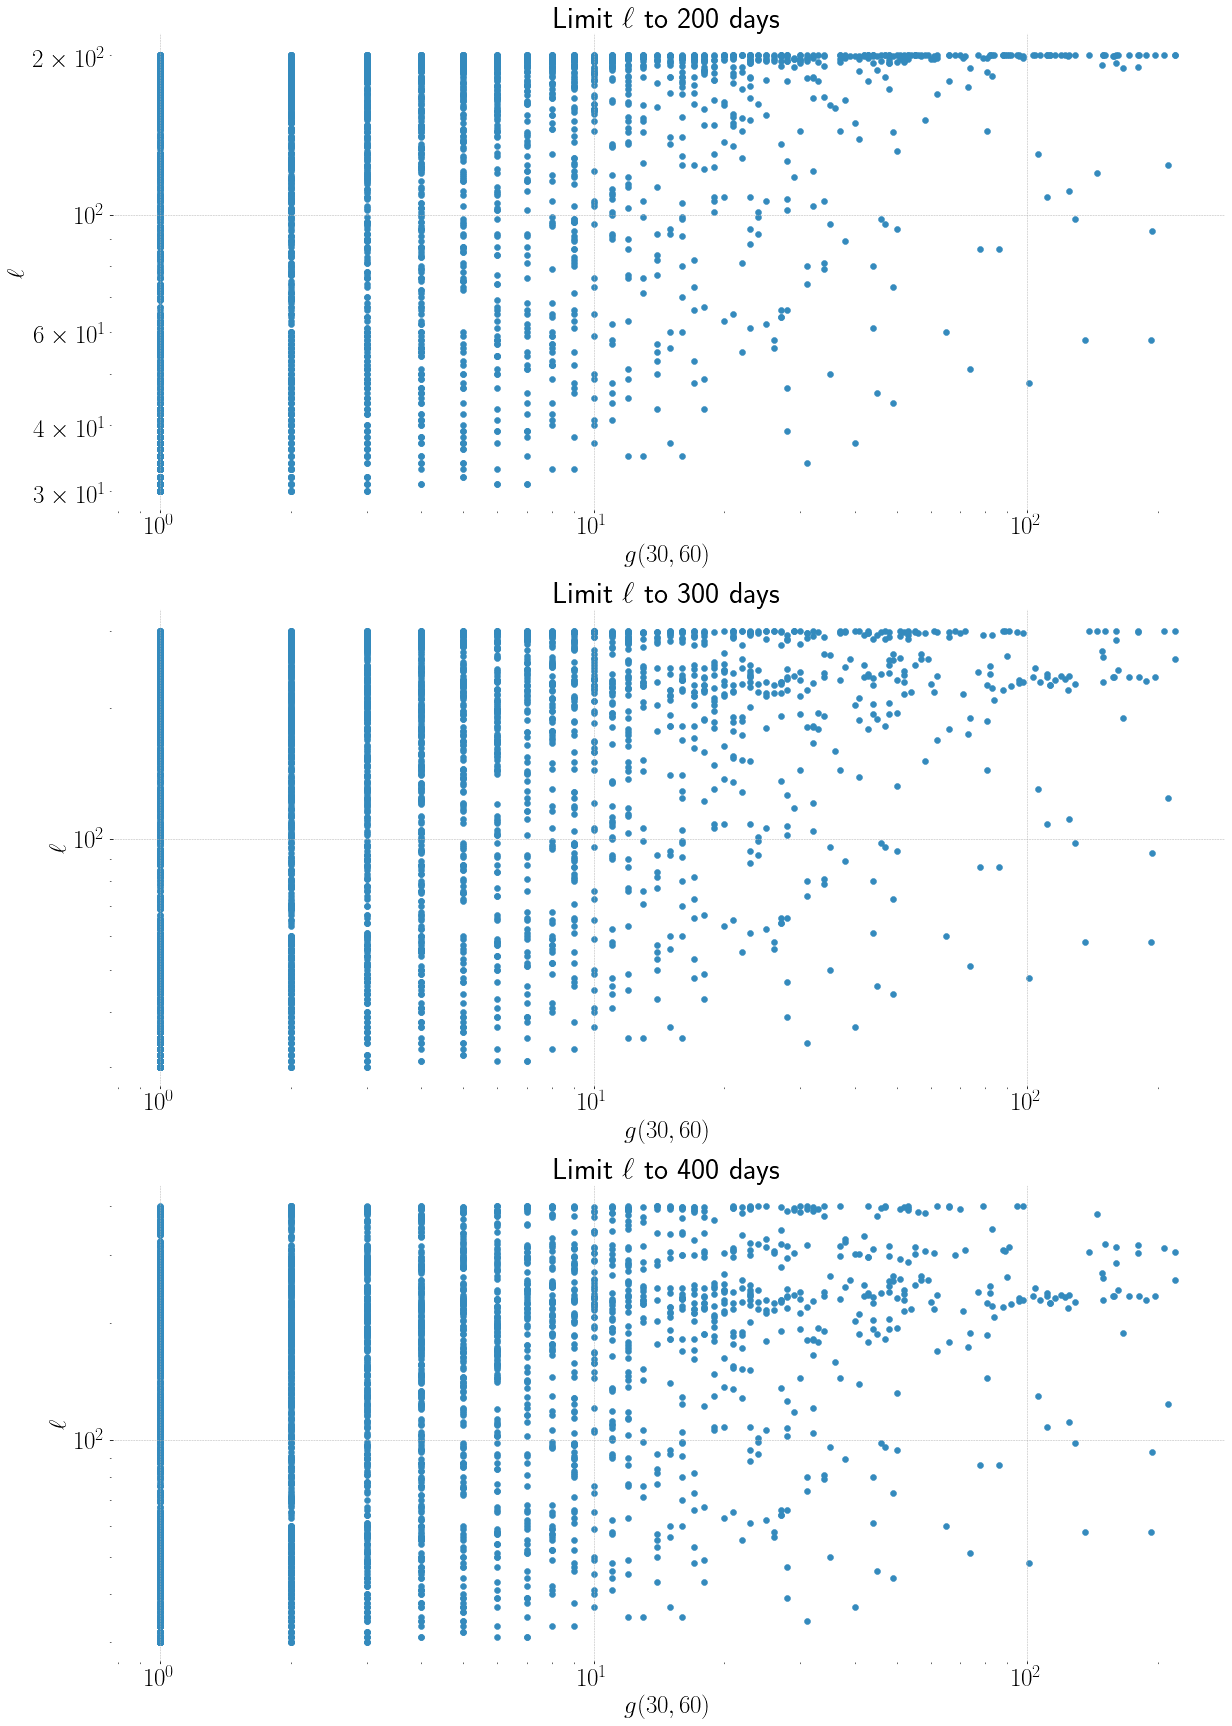

In [60]:
plt.figure(figsize=(20, 30))
days = [15, 30, 60]
for p in range(3):
    plt.subplot(3,1,p + 1)
    plt.title(fr"Limit $\ell$ to {maxell[p]} days")
    plt.ylabel(r"$\ell$")
    plt.xlabel(r"$g(30, 60)$")
    plt.loglog()
    #plt.ylim(0, 550)
    plt.scatter([i[0] for i in gl[p + 4]], [i[1] for i in gl[p + 4]])

## Doing all of the above, while separating cohorts 

In [61]:
def get_scatter(df, lives, ao=30, af=60):
    points = []
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter]
            df3 = df2.loc[(df2['aclock'] >= ao) & (df2['aclock'] <= af)]
            if len(df3) > 0:
                points.append((len(df3), lives[ego][alter]['ell']))
    return points

In [62]:
livesog['mit'] = pc.lives_dictionary(callsog['mit'])

In [63]:
glc = {}
for c in ['uk1', 'uk2', 'mit']:
    glc[c] = []
    glc[c].append(get_scatter(callsog[c], livesog[c]))

In [64]:
for c in glc.keys():
    tmp = {}
    uno = callsog[c].groupby('ego')[['uclock']].min()
    for d in [15, 30, 60]:
        dos = pd.DataFrame()
        for ego in callsog[c]['ego'].unique():
            df = callsog[c].loc[callsog[c]['ego'] == ego]
            minday = uno.loc[ego]['uclock'] + d
            df1 = df.loc[df['uclock'] >= minday]
            dos = dos.append(df1).reset_index(drop=True)
        old = len(callsog['all'])
        tmp[d] = dos
        glc[c].append(get_scatter(tmp[d], livesog[c]))
        print(f'Cohort {c}: {d} days lost {old - len(tmp[d])} calls')

Cohort uk1: 15 days lost 199599 calls
Cohort uk1: 30 days lost 202256 calls
Cohort uk1: 60 days lost 207284 calls
Cohort uk2: 15 days lost 241511 calls
Cohort uk2: 30 days lost 242513 calls
Cohort uk2: 60 days lost 245502 calls
Cohort mit: 15 days lost 117367 calls
Cohort mit: 30 days lost 126640 calls
Cohort mit: 60 days lost 146641 calls


In [65]:
for c in glc.keys():
    for maxell in [200, 300, 400]:
        old = len(callsog[c])
        df = callsog[c].loc[callsog[c]['aclock'] <= maxell]
        livesalt = pc.lives_dictionary(df)
        print(f'Limit of {maxell} days lost {old - len(df)} calls')
        glc[c].append(get_scatter(df, livesalt))

Limit of 200 days lost 37748 calls
Limit of 300 days lost 24120 calls
Limit of 400 days lost 12901 calls
Limit of 200 days lost 3229 calls
Limit of 300 days lost 254 calls
Limit of 400 days lost 0 calls
Limit of 200 days lost 24426 calls
Limit of 300 days lost 1567 calls
Limit of 400 days lost 77 calls


In [66]:
# mkdir params

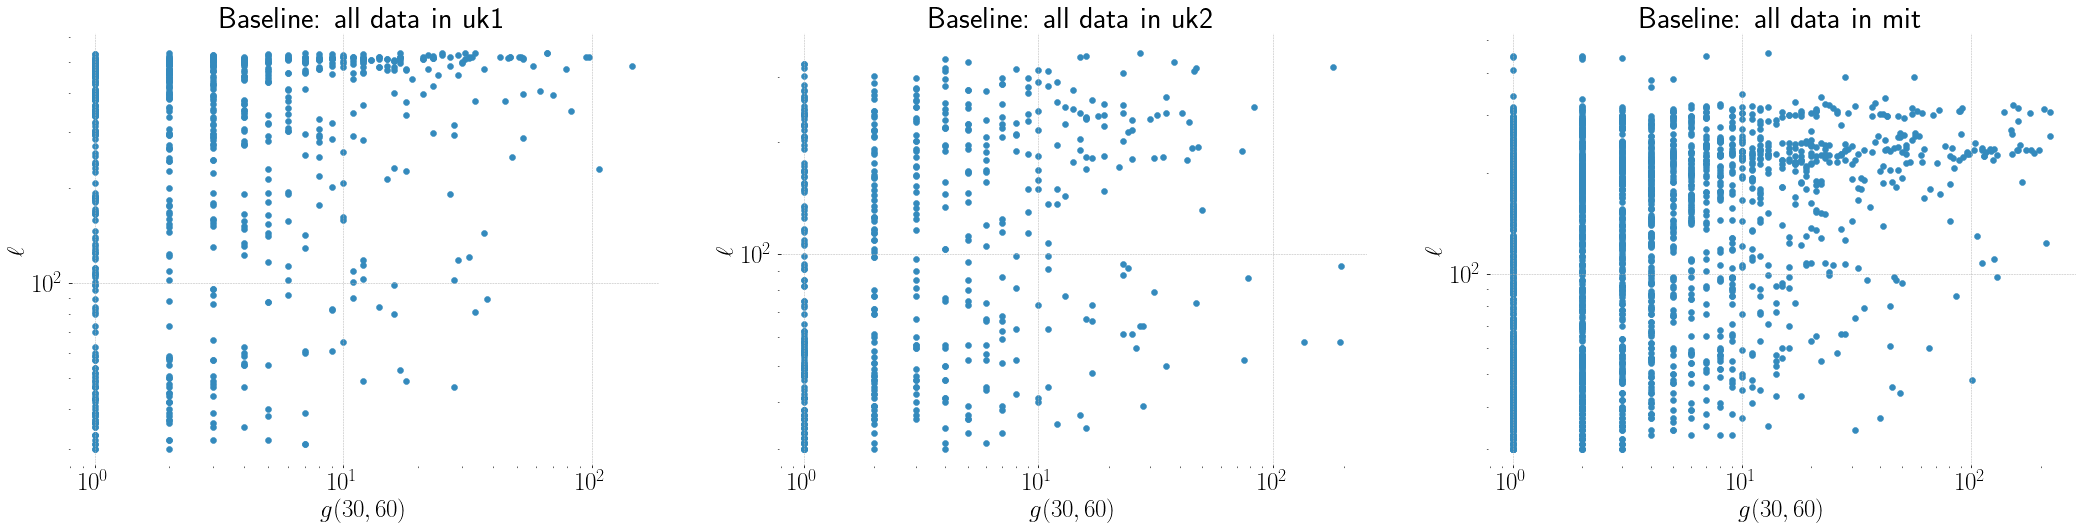

In [68]:
cohorts = ['uk1', 'uk2', 'mit']
plt.figure(figsize=(36, 8))
for p in range(3):
    plt.subplot(1,3,p + 1)
    plt.title(f'Baseline: all data in {cohorts[p]}')
    plt.xlabel(r"$g(30, 60)$")
    plt.ylabel(r"$\ell$")
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter([x[0] for x in glc[cohorts[p]][0]], [y[1] for y in glc[cohorts[p]][0]])
#plt.savefig("params/page1.pdf", dpi=200)

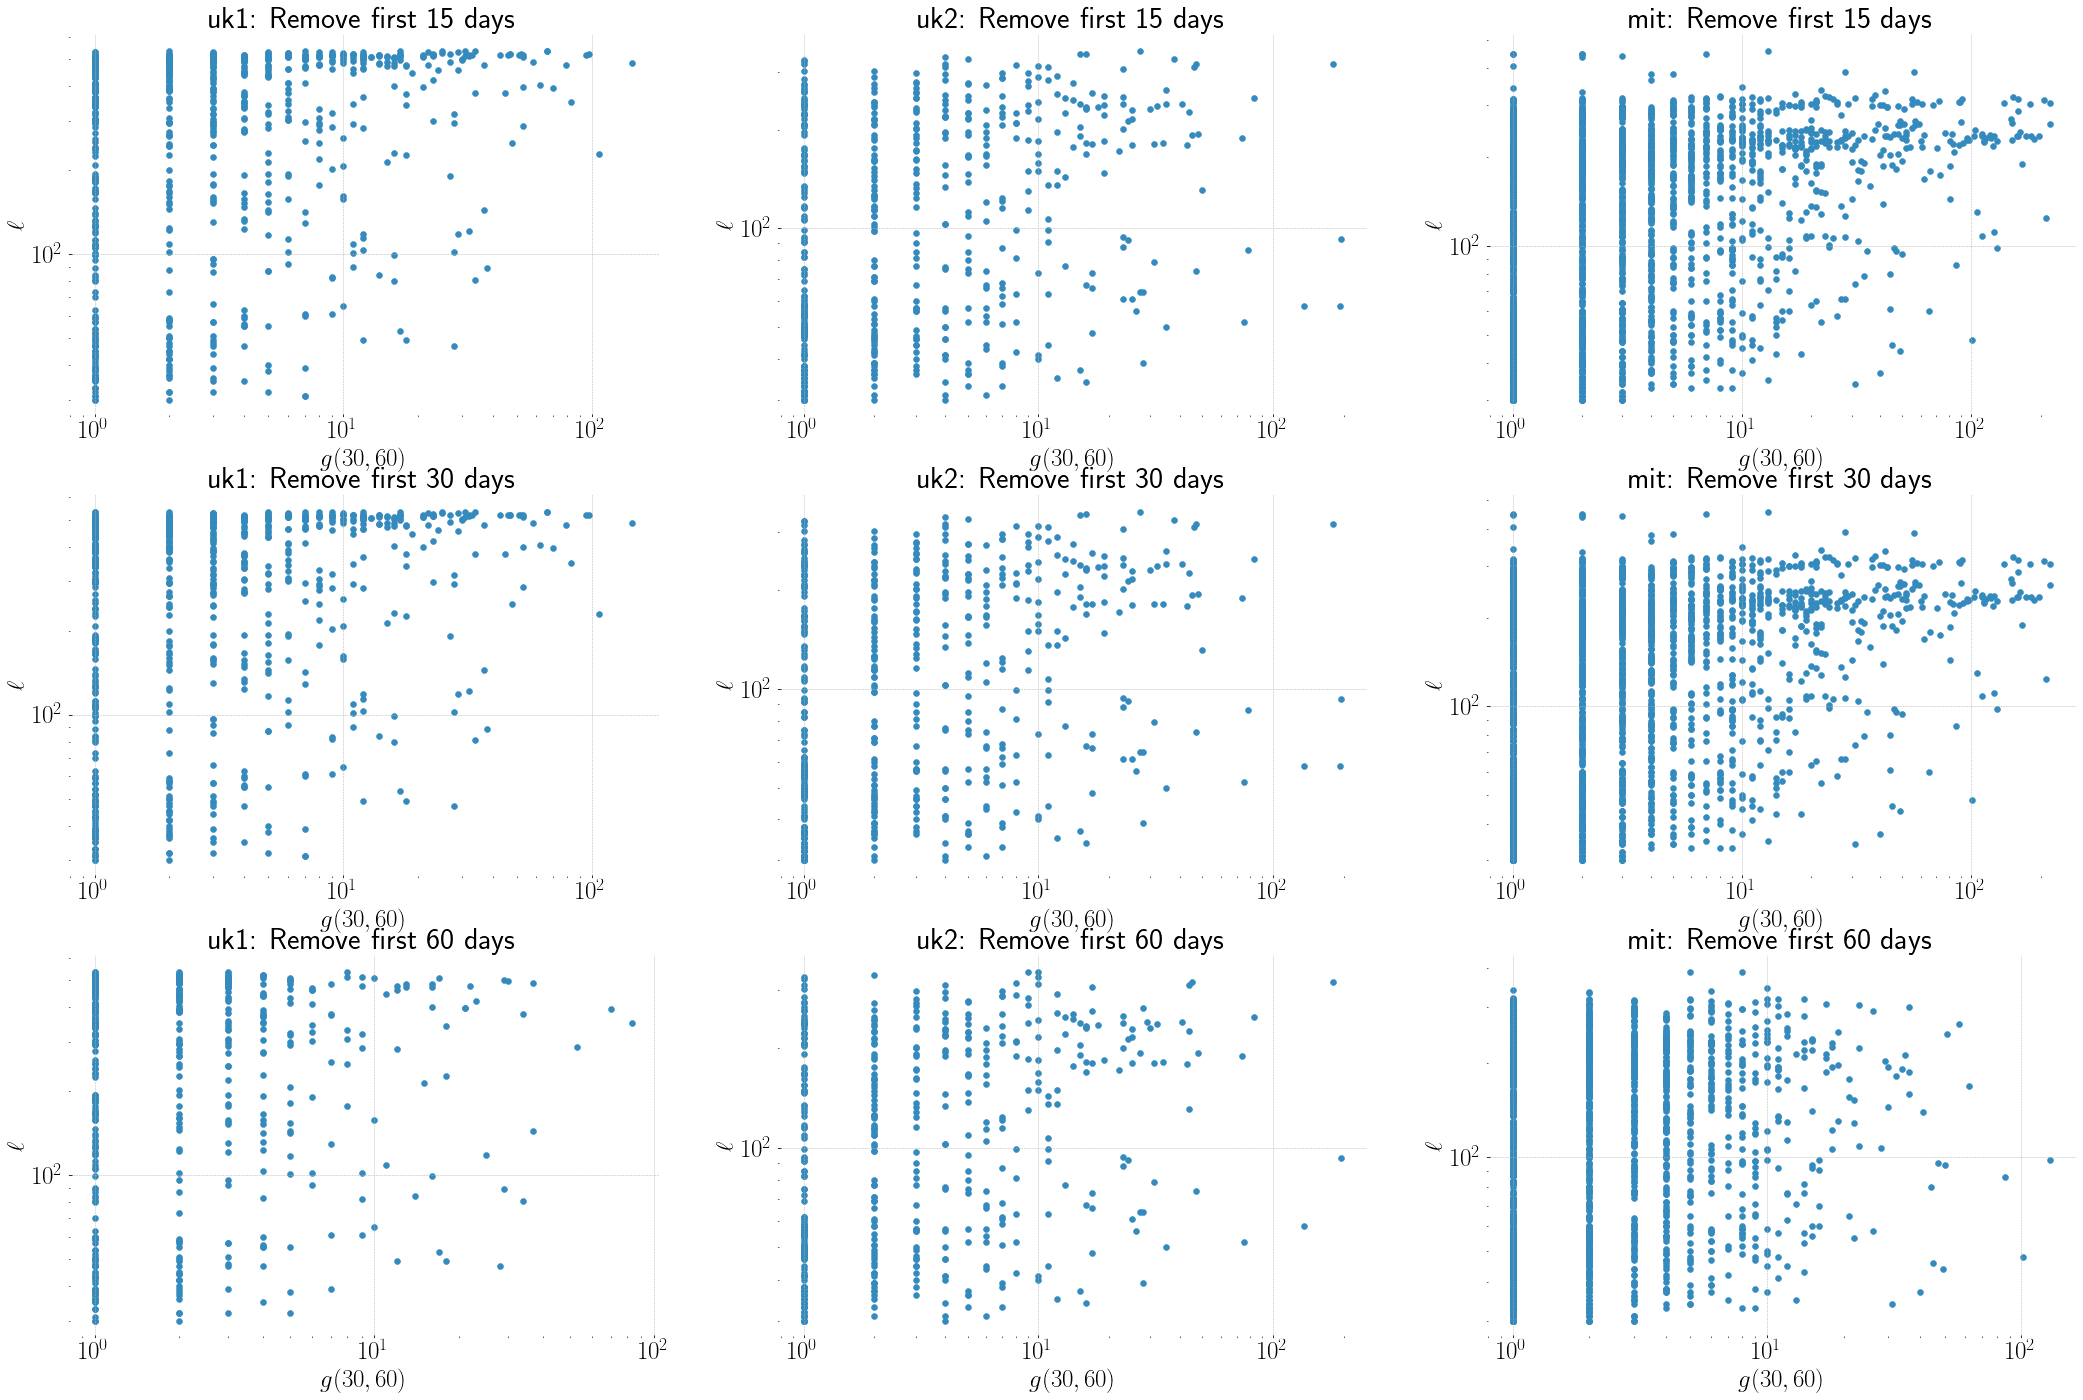

In [69]:
plt.figure(figsize=(36, 24))
for p in range(9):
    plt.subplot(3,3,p + 1)
    plt.title(f'{cohorts[p % 3]}: Remove  first {days[p//3]} days')
    plt.xlabel(r"$g(30, 60)$")
    plt.ylabel(r"$\ell$")
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter([x[0] for x in glc[cohorts[p % 3]][1 + (p//3)]], [y[1] for y in glc[cohorts[p % 3]][1 + (p//3)]])
#plt.savefig("params/page2.pdf", dpi=200)

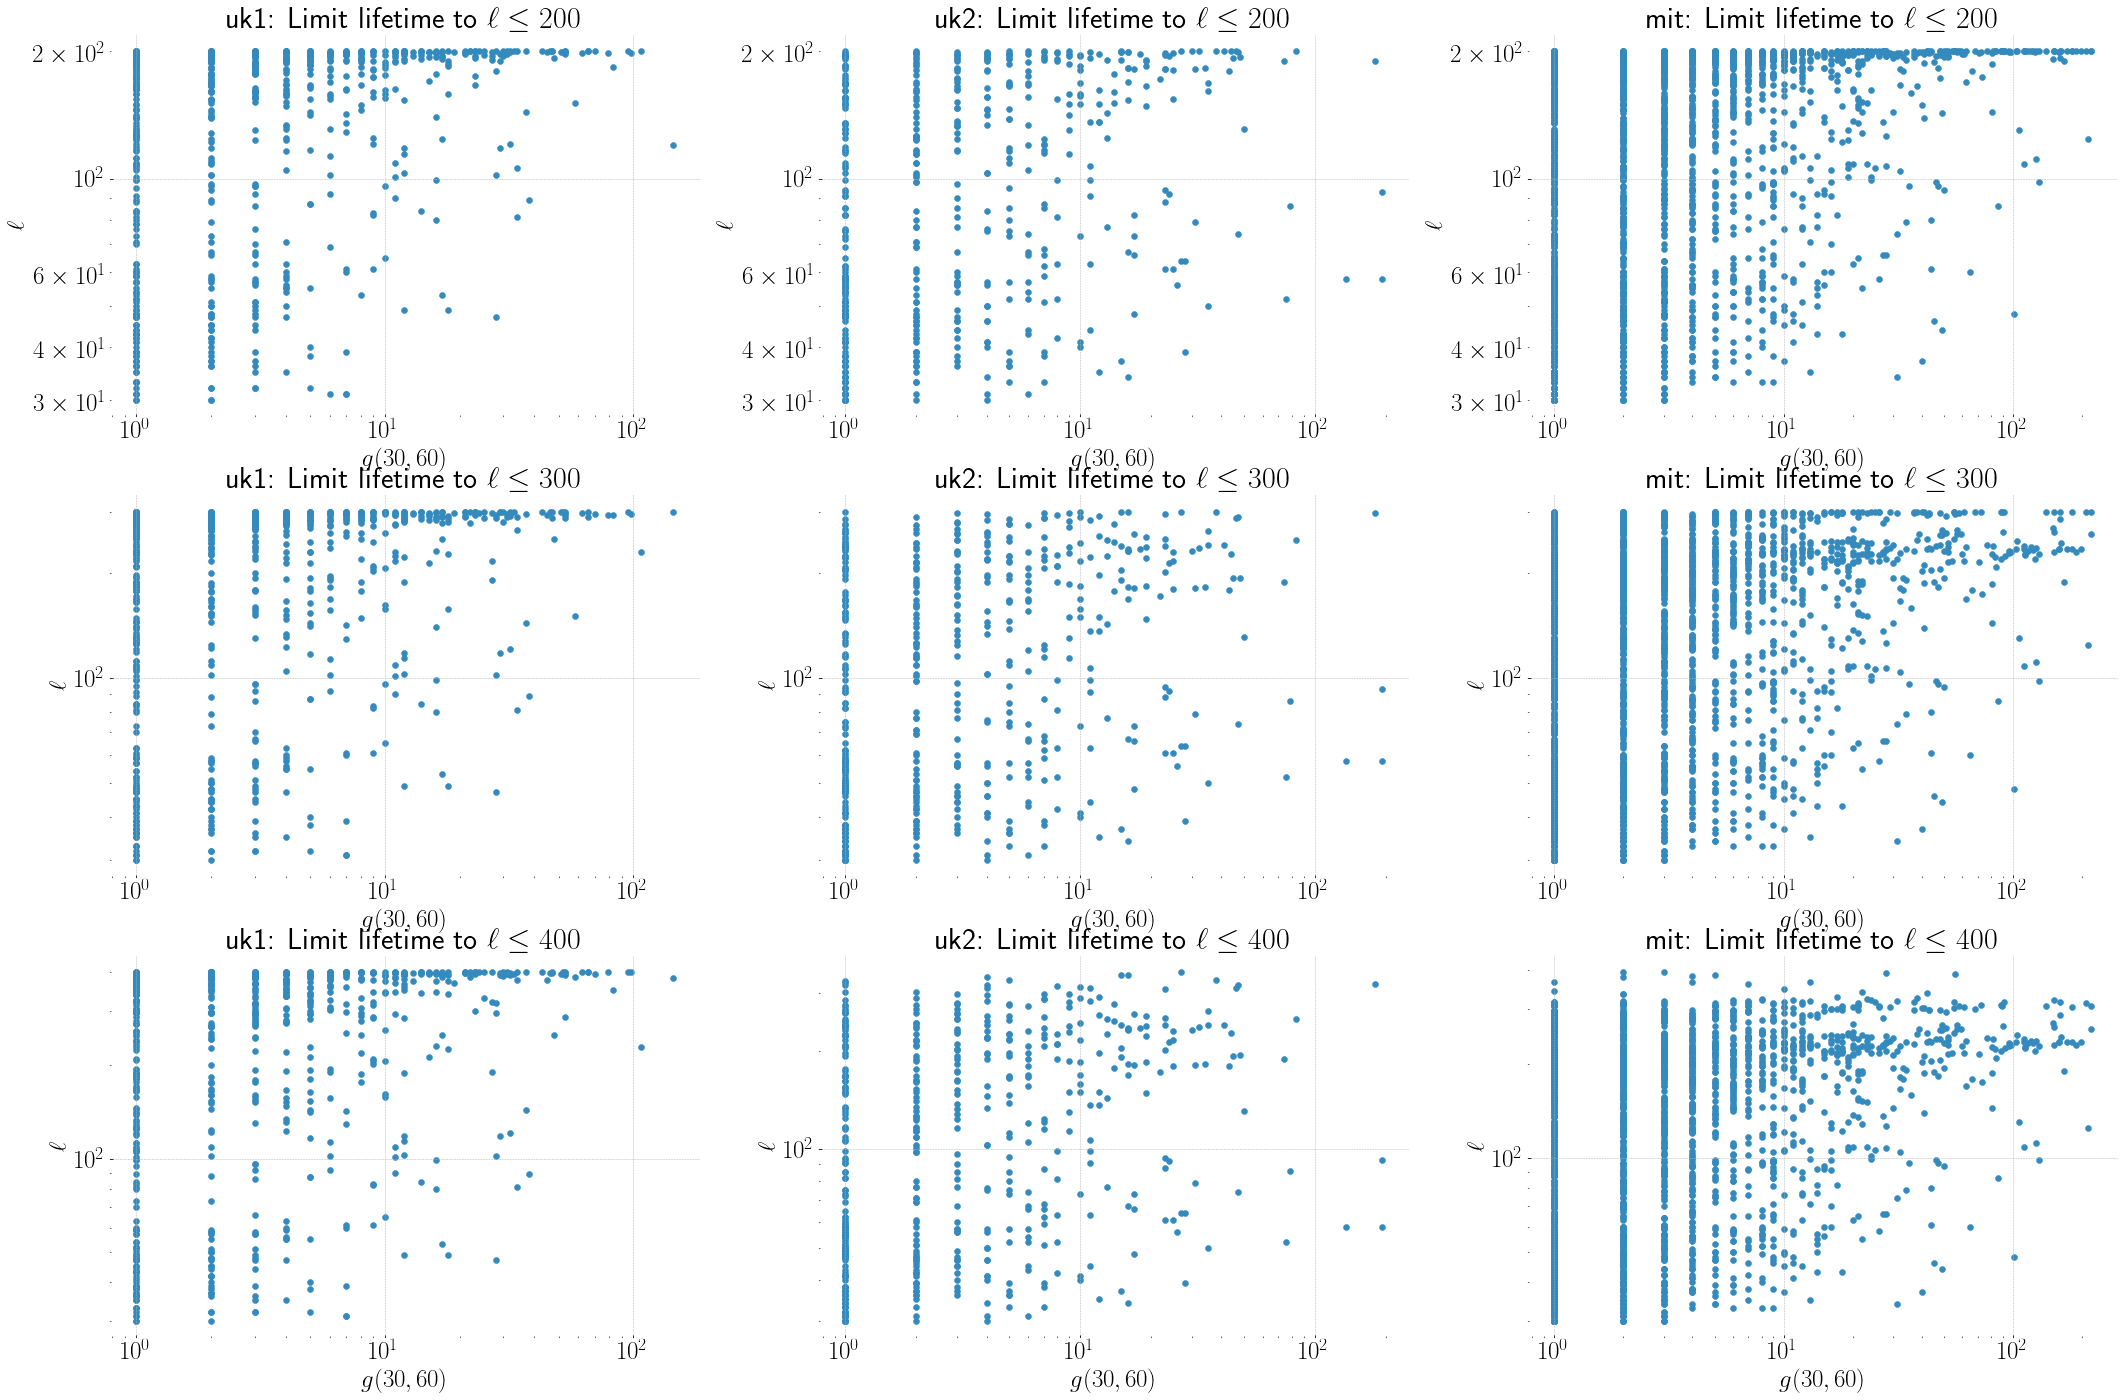

In [70]:
maxell = [200, 300, 400]
plt.figure(figsize=(36, 24))
for p in range(9):
    plt.subplot(3,3,p + 1)
    plt.title(fr'{cohorts[p % 3]}: Limit lifetime to $\ell \leq {maxell[p//3]}$')
    plt.xlabel(r"$g(30, 60)$")
    plt.ylabel(r"$\ell$")
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter([x[0] for x in glc[cohorts[p % 3]][4 + (p//3)]], [y[1] for y in glc[cohorts[p % 3]][4 + (p//3)]])
#plt.savefig("params/page3.pdf", dpi=200)

## Now looking at figures 2 and 3

Cohort by cohort, kkeping the cores and respecting the limits on egos and alters. First, prepare data by removing 30 days from egos

In [71]:
updated = {}
for c in ['uk1', 'uk2', 'mit']:
    uno = callsog[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in callsog[c]['ego'].unique():
        df = callsog[c].loc[callsog[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(callsog[c])
    updated[c] = dos
    print(f'{c} lost {old - len(updated[c])} calls')

uk1 lost 5733 calls
uk2 lost 1684 calls
mit lost 19098 calls


Now limit alters' lives to 200

In [72]:
for c in updated.keys():
    old = len(updated[c])
    updated[c] = updated[c].loc[updated[c]['aclock'] <= 200]
    print(f'{c} lost {old - len(updated[c])} calls')

uk1 lost 37748 calls
uk2 lost 3229 calls
mit lost 24426 calls


Together with the previous change, I also have to remove all alters that could have not reached 200 days because they entered the data too late

In [73]:
for c in updated.keys():
    uno = pd.DataFrame()
    T = max(updated[c]['uclock'])
    for ego in updated[c]['ego'].unique():
        df = updated[c].loc[updated[c]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df2.loc[:, 'aclock'] = df2['uclock'] - mint
                uno = uno.append(df2).reset_index(drop=True)
    old = len(updated[c].groupby(['ego', 'alter'])[['aclock']].count())
    updated[c] = uno
    new = len(updated[c].groupby(['ego', 'alter'])[['aclock']].count())
    print(f'{c} lost {old - new} pairs of ego-alter')

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


uk1 lost 38 pairs of ego-alter
uk2 lost 1905 pairs of ego-alter
mit lost 7649 pairs of ego-alter


In [74]:
dff_up2 = {}
for c in updated.keys():
    dff_up2[c] = pc.get_f(updated[c], 'all', 10, 70)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [75]:
up_fig2 = {}
for c in updated.keys():
    b = pc.get_b(dff_up2[c], 'alpha')
    up_fig2[c] = pc.plot_g(b, 'alpha')

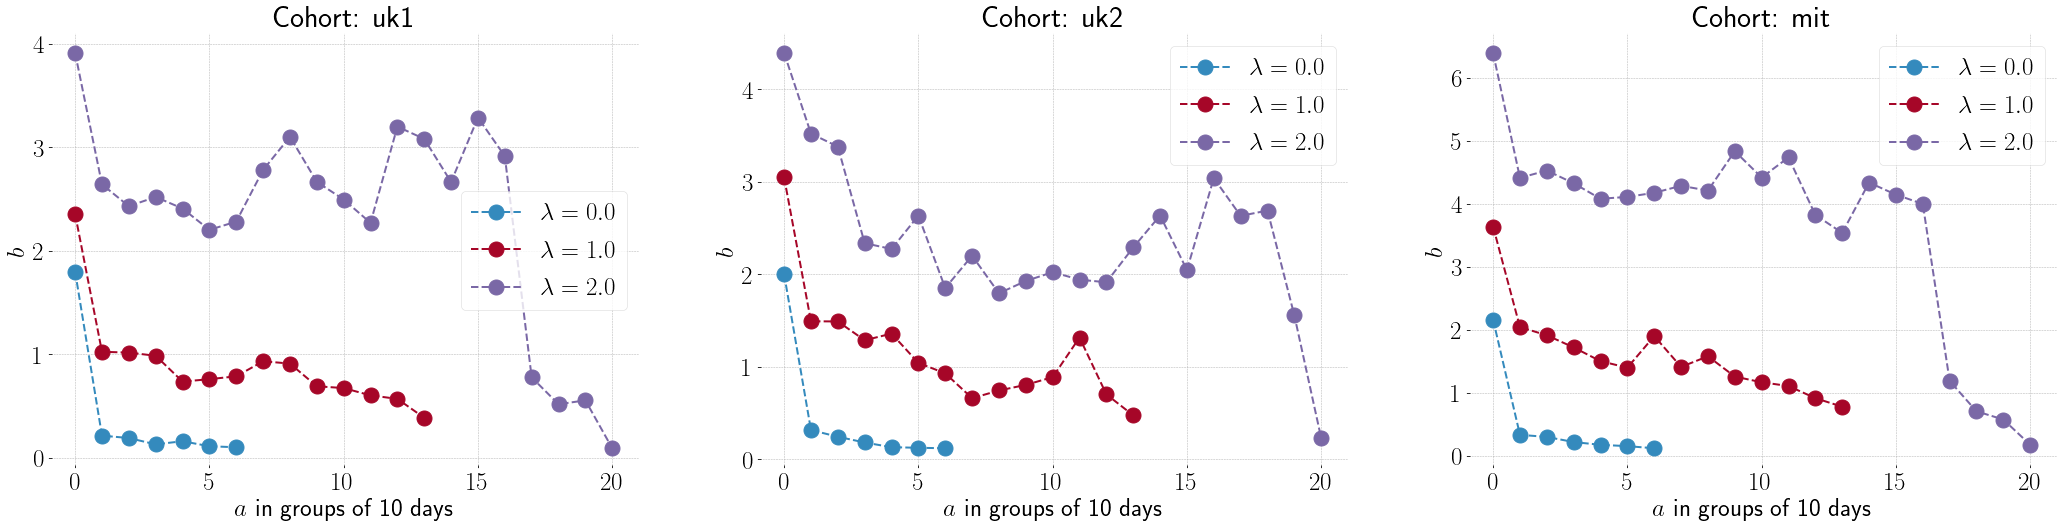

In [76]:
cohorts = ['uk1', 'uk2', 'mit']
plt.figure(figsize=(36, 8))
for p in range(3):
    plt.subplot(1,3,p+1)
    plt.title(f'Cohort: {cohorts[p]}')
    plt.xlabel(r'$a$ in groups of 10 days')
    plt.ylabel(r'$b$')
    df = up_fig2[cohorts[p]]
    for l in df.keys():
        plt.plot(df[l].index, df[l]['alpha'], marker="o", markersize=15, ls="--", c=colors[int(l)], label=fr'$\lambda = {l}$')
    plt.legend()

And now, update fig 3

In [77]:
dff_up3 = {}
for c in updated.keys():
    dff_up3[c] = pc.get_f(updated[c], 'all', 30, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [78]:
up_fig3 = {}
for c in updated.keys():
    up_fig3[c] = pc.get_survival(dff_up3[c])

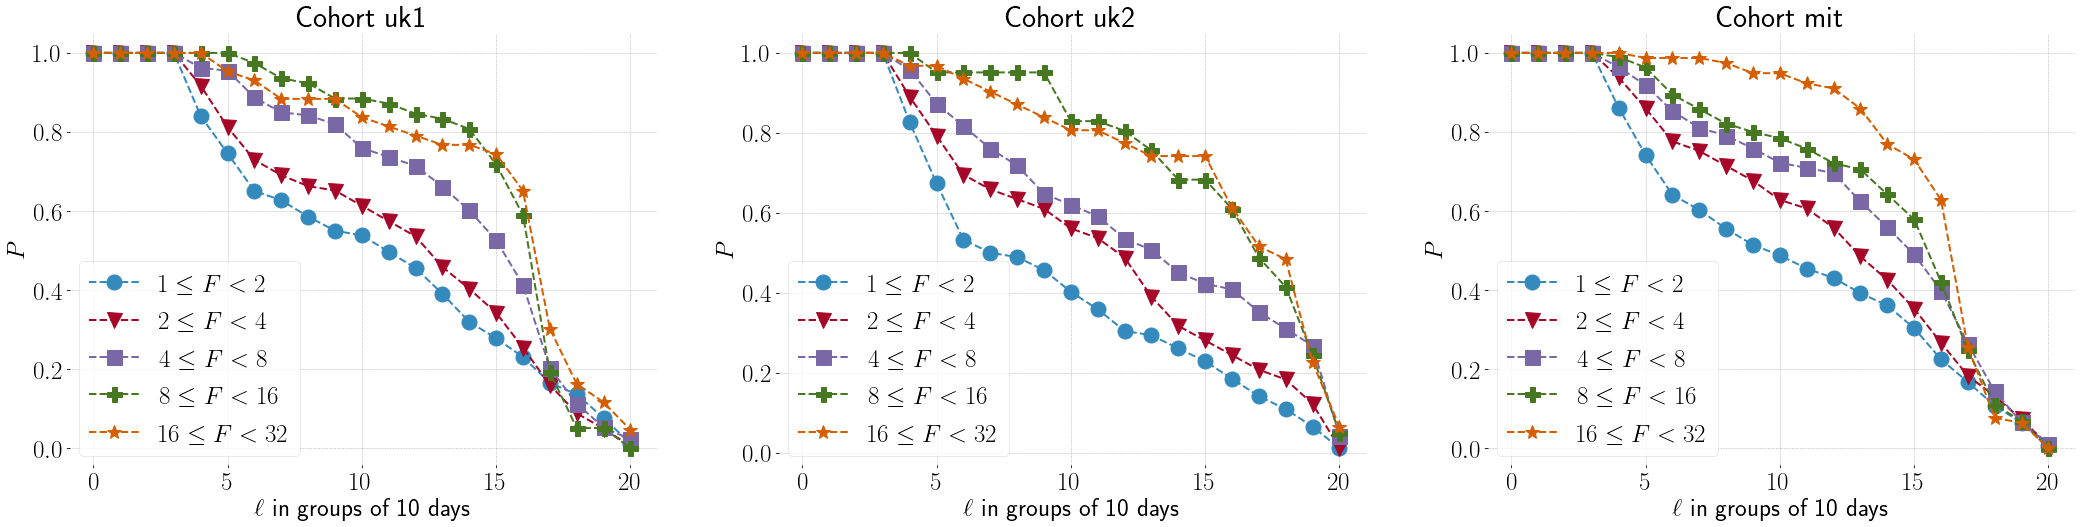

In [79]:
plt.figure(figsize=(36, 8))
for p in range(3):
    plt.subplot(1, 3, p+1)
    plt.title(f'Cohort {cohorts[p]}')
    plt.xlabel(r"$\ell$ in groups of 10 days")
    plt.ylabel(r"$P$")
    series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(5)]
    df = up_fig3[cohorts[p]]
    for F in range(5):
        plt.plot(df[F].index, df[F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
    plt.legend()

In [80]:
uno = callsog['uk'].groupby('ego')[['uclock']].min()
dos = pd.DataFrame()
for ego in callsog['uk']['ego'].unique():
    df = callsog['uk'].loc[callsog['uk']['ego'] == ego]
    minday = uno.loc[ego]['uclock'] + 30
    df1 = df.loc[df['uclock'] >= minday]
    dos = dos.append(df1).reset_index(drop=True)
old = len(callsog['uk'])
updated['uk'] = dos

In [81]:
updated['uk'] = updated['uk'].loc[updated['uk']['aclock'] <= 200]

In [82]:
uno = pd.DataFrame()
T = max(updated['uk']['uclock'])
for ego in updated['uk']['ego'].unique():
    df = updated['uk'].loc[updated['uk']['ego'] == ego]
    for alter in df['alter'].unique():
        df2 = df.loc[df['alter'] == alter]
        mint = min(df2['uclock'])
        if mint < (T - 200):
            df2.loc[:, 'aclock'] = df2['uclock'] - mint
            uno = uno.append(df2).reset_index(drop=True)
updated['uk'] = uno

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [83]:
dff1_uk = pc.get_f(updated['uk'], 'all', 10, 70)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [84]:
b = pc.get_b(dff1_uk, 'alpha')
up1_uk = pc.plot_g(b, 'alpha')

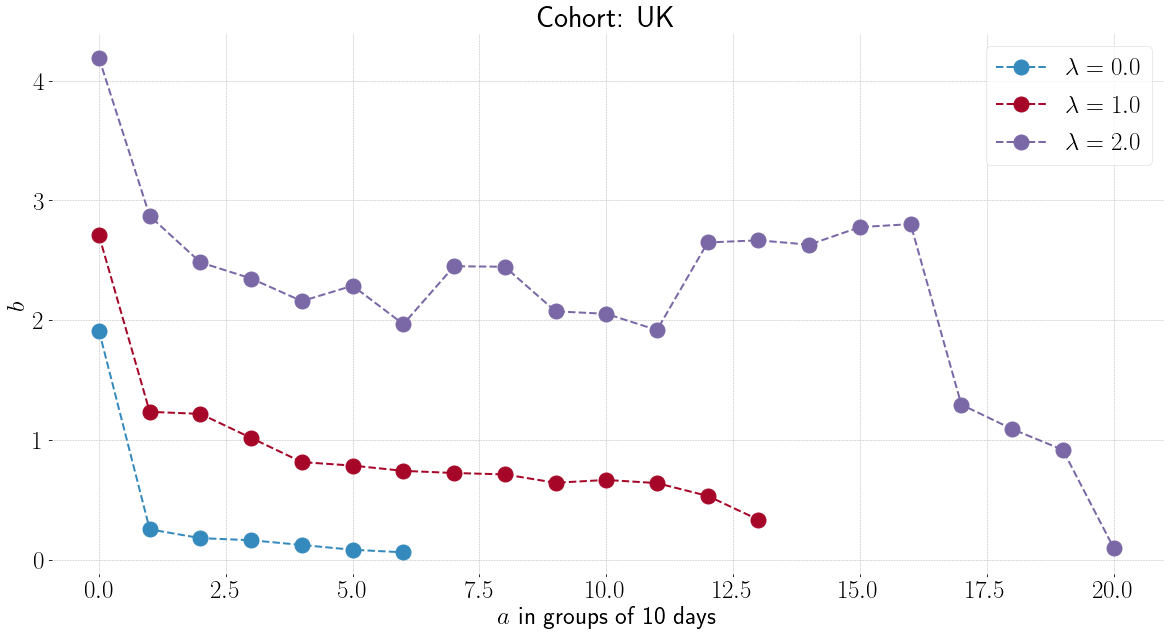

In [85]:
plt.title(f'Cohort: UK')
plt.xlabel(r'$a$ in groups of 10 days')
plt.ylabel(r'$b$')
df = up1_uk
for l in df.keys():
    plt.plot(df[l].index, df[l]['alpha'], marker="o", markersize=15, ls="--", c=colors[int(l)], label=fr'$\lambda = {l}$')
plt.legend()

In [86]:
dff2_uk = pc.get_f(updated['uk'], 'all', 30, 10)
up2_uk = pc.get_survival(dff2_uk)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


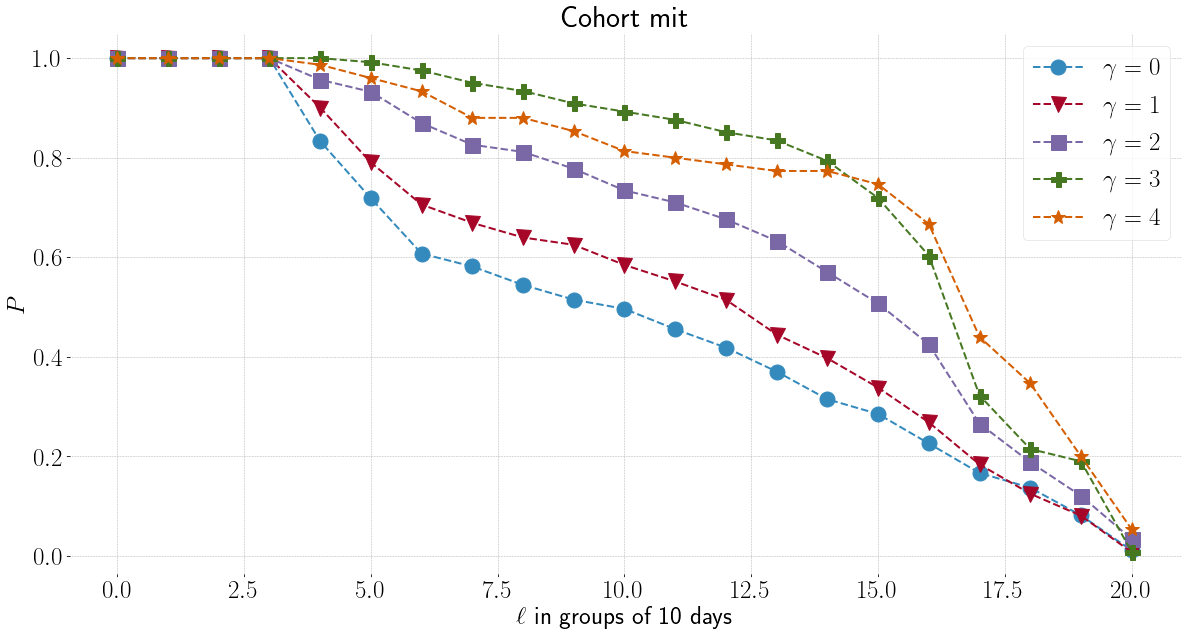

In [87]:
plt.title(f'Cohort {cohorts[p]}')
plt.xlabel(r"$\ell$ in groups of 10 days")
plt.ylabel(r"$P$")
series2 = [f'$\gamma = {i}$' for i in range(5)]
df = up2_uk
for F in range(5):
    plt.plot(df[F].index, df[F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.legend()

# Export data to pickles

In [105]:
# with open('unfiltered.pkl', 'wb') as handle:
#     pickle.dump(callsog, handle, protocol=pickle.HIGHEST_PROTOCOL)
# handle.close()

before running the following cell, make sure to check that the filtered dictionary of dataframes contains all five cohorts, or at least that it matches the `callsog` dictionary

In [97]:
# with open('filtered.pkl', 'wb') as handle:
#     pickle.dump(calls, handle)
# handle.close()

Now for the filtered dictionary without cores, keep in mind that cores of size 3 were used.

In [98]:
t0 = time.time()
cores = {}
for c in callsog.keys():
    cores[c] = {}
    for ego in callsog[c]['ego'].unique():
        df = callsog[c].loc[callsog[c]['ego'] == ego]
        thecore = list(df.groupby('alter')[['aclock']].max().sort_values(by='aclock').index)[-3:]
        cores[c][ego] = thecore
print(f'This block took {time.time() - t0}')

This block took 3.205059289932251


In [103]:
t0 = dt.datetime.now()

filterednc = {}
for c in calls.keys():
    df = calls[c]
    filterednc[c] = pd.DataFrame()
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        tmp = ~df1['alter'].isin(cores[c][ego])
        df2 = df1.loc[tmp]
        filterednc[c] = filterednc[c].append(df2).reset_index(drop=True)

print(f'This block took {dt.datetime.now() - t0}')

This block took 0:00:02.185688


In [104]:
# with open('filterednc.pkl', 'wb') as handle:
#     pickle.dump(filterednc, handle)
# handle.close()